<a href="https://colab.research.google.com/github/roxyrong/w281-project/blob/main/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 3.01 s (started: 2023-12-05 16:56:27 +00:00)


In [ ]:
import os
import copy
from glob import glob
import numpy as np
from numpy import fft
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from skimage.feature import hog, canny
# from skimage.transform import hough_line
import cv2

from PIL import Image, ImageStat
import matplotlib.pyplot as plt
import seaborn as sns
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score

time: 1.84 ms (started: 2023-12-05 17:40:22 +00:00)


In [ ]:
%%capture
!pip install ipython-autotime
%load_ext autotime

time: 10.3 s (started: 2023-12-05 16:56:30 +00:00)


# Data Loading & Cleaning

In [ ]:
def load_dataset(datapath):
    df = pd.DataFrame()

    for folder in os.listdir(datapath):
      files = glob(pathname= str(datapath + folder + '/*.jpg'))
      df = pd.concat([df, pd.DataFrame( { 'filename': files ,
                                          'category': folder } ) ])

    df = df.reset_index(drop=True)

    df = df.sample(frac=0.2)

    df['image'] = None
    df['gray_image'] = None
    df['hsv_image'] = None
    df['resolution'] = None
    for idx, row in df.iterrows():
      img = Image.open(row['filename'])
      df.at[idx, 'image'] = np.array(img, dtype=np.float32)
      df.at[idx, 'gray_image'] = np.array(img.convert('L'))
      df.at[idx, 'hsv_image'] = np.array(img.convert('HSV'))
      df.at[idx, 'resolution']  = img.size

    return df

time: 973 µs (started: 2023-12-05 16:56:41 +00:00)


In [ ]:
train_path = 'drive/MyDrive/github/w281-project-me/dataset/seg_train/seg_train/'
test_path = 'drive/MyDrive/github/w281-project-me/dataset/seg_test/seg_test/'
train_df = load_dataset(train_path)
test_df = load_dataset(test_path)
train_df = train_df[train_df['resolution'] == (150, 150)]
test_df = test_df[test_df['resolution'] == (150, 150)]

time: 9min 32s (started: 2023-12-05 16:56:41 +00:00)


In [ ]:
print(train_df.groupby("category")["image"].count())
print(test_df.groupby("category")["image"].count())

category
buildings    407
forest       463
glacier      487
mountain     520
sea          434
street       487
Name: image, dtype: int64
category
buildings     98
forest        94
glacier      105
mountain     100
sea          101
street       100
Name: image, dtype: int64
time: 10.9 ms (started: 2023-12-05 17:06:13 +00:00)


# Feature Engineering

In [ ]:
## HOG feature
def add_hog_feature(row):
  row['hog_feature'], row['hog_image'] = hog(row['image'],
                                             orientations=8,
                                             pixels_per_cell=(15, 15),
                                             cells_per_block=(1, 1),
                                             visualize=True,
                                             channel_axis=-1)

  return row

time: 770 µs (started: 2023-12-05 17:06:14 +00:00)


In [ ]:
## Canny Edge Detection
def add_canny_feature(row):
  row['canny_feature'] = canny(row["gray_image"], sigma=1)
  return row

time: 665 µs (started: 2023-12-05 17:06:14 +00:00)


In [ ]:
def add_fourier_feature(row):
  image = row["gray_image"]
  ydim = image.shape[0]
  xdim = image.shape[1]
  win = np.outer(np.hanning(ydim), np.hanning(xdim))
  win = win/np.mean(win)
  fourier = fft.fftshift(fft.fft2(image * win))
  Fmag = np.abs(fourier)
  row["fourier_feature"] = np.log(Fmag)
  return row

time: 763 µs (started: 2023-12-05 17:06:14 +00:00)


In [ ]:
## HED Edge Detection
## https://github.com/s9xie/hed

def blob_batch_processing(original_images):
  images = copy.deepcopy(original_images)
  images = images.apply(lambda x: cv2.resize(x, (299, 299)))
  images = np.array(images)
  blob = cv2.dnn.blobFromImages(images, scalefactor=1, size=(299, 299),
    mean=(105, 117, 123), #MODEL MEAN VALUE
    swapRB=True, crop=False)
  blob = list(blob)
  blob = [b[np.newaxis, :]for b in blob]
  return blob

# The pre-trained model that OpenCV uses has been trained in Caffe framework
proto_path = 'drive/MyDrive/github/w281-project-me/third_party/HED/deploy.prototxt'
model_path = 'drive/MyDrive/github/w281-project-me/third_party/HED/hed_pretrained_bsds.caffemodel'
net = cv2.dnn.readNetFromCaffe(proto_path, model_path)

def add_HED_feature(row):
  net.setInput(row['blob'])
  hed = net.forward()
  hed = cv2.resize(np.squeeze(hed), (150, 150))
  hed = cv2.cvtColor(hed, cv2.COLOR_GRAY2BGR)
  hed = (255 * hed).astype("uint8")
  row['hed'] = hed
  return row


time: 226 ms (started: 2023-12-05 17:06:14 +00:00)


In [ ]:
vgg_model = VGG16(include_top=False, input_shape=(150, 150, 3))

def add_vgg_feature(row):
  image = row['image']
  image = np.expand_dims(image, axis=0)
  image = preprocess_input(image)
  row['vgg16_feature'] = vgg_model.predict(image, verbose=False).flatten()
  return row

time: 537 ms (started: 2023-12-05 17:06:14 +00:00)


In [ ]:
#HOG: shape = (800, 0)
train_df = train_df.apply(add_hog_feature, axis=1)
#Canny: shape = (150, 150)
# train_df = train_df.apply(add_canny_feature, axis=1)
#HED shape = (150, 150, 3)
# train_df['blob'] = blob_batch_processing(train_df['image'])
# train_df = train_df.apply(add_HED_feature, axis=1)
#VGG16 (8192, 0)
train_df = train_df.apply(add_vgg_feature, axis=1)
#fourier: shape = (150, 150)
# train_df = train_df.apply(add_fourier_feature, axis=1)

time: 19min 11s (started: 2023-12-05 17:06:14 +00:00)


In [ ]:
test_df = test_df.apply(add_hog_feature, axis=1)
#Canny: shape = (150, 150)
# test_df = test_df.apply(add_canny_feature, axis=1)
#HED shape = (150, 150, 3)
# test_df['blob'] = blob_batch_processing(train_df['image'])
# test_df = test_df.apply(add_HED_feature, axis=1)
#VGG16 (8192, 0)
test_df = test_df.apply(add_vgg_feature, axis=1)
#fourier: shape = (150, 150)
# test_df = test_df.apply(add_fourier_feature, axis=1)

time: 3min 59s (started: 2023-12-05 17:25:25 +00:00)


# Feature Selection

In [ ]:
def pca_analysis(df, features, num_components):

    if not isinstance(num_components, list) or len(num_components) != len(features):
        raise ValueError("num_components must be a list of the same length as features")

    num_features = len(features)

    fig, axs = plt.subplots(num_features, 1, figsize=(6, num_features * 4))
    fig.tight_layout(pad=4.0)

    for idx, f in enumerate(features):
        feature_vector = np.stack(df[f].to_numpy())

        explained_variance = []
        max_components = min(num_components[idx], len(df))

        for components in range(5, max_components + 1, 5):
            pca = PCA(n_components=components)
            pca.fit(feature_vector)
            total_variance = np.sum(pca.explained_variance_ratio_)
            explained_variance.append(total_variance)

        axs[idx].plot(x=range(5, max_components + 1, 5), y=explained_variance)
        axs[idx].set_title(f"PCA for {f}")
        axs[idx].set_xlabel("Number of Components")
        axs[idx].set_ylabel("Explained Variance")

    plt.show()

time: 5.65 ms (started: 2023-12-05 17:29:25 +00:00)


In [ ]:
# pca_analysis(train_df, ["hog_feature", "vgg16_feature"], [800, 8192])

time: 450 µs (started: 2023-12-05 17:29:25 +00:00)


In [ ]:
pca = PCA(n_components=100)
pca.fit(np.stack(train_df["hog_feature"].to_numpy()))
train_df["pca_hog"] = list(pca.transform(np.stack(train_df["hog_feature"].to_numpy())))
test_df["pca_hog"] = list(pca.transform(np.stack(test_df["hog_feature"].to_numpy())))

# train_df["pca_hog"] = list(pca.fit_transform(np.stack(train_df["hog_feature"].to_numpy())))
pca = PCA(n_components=150)
pca.fit(np.stack(train_df["vgg16_feature"].to_numpy()))
train_df["pca_vgg16"] = list(pca.transform(np.stack(train_df["vgg16_feature"].to_numpy())))
test_df["pca_vgg16"] = list(pca.transform(np.stack(test_df["vgg16_feature"].to_numpy())))

time: 9.55 s (started: 2023-12-05 17:29:25 +00:00)


# Modeling

In [ ]:
X_train = np.hstack((np.stack(train_df["pca_hog"].to_numpy()),
                     np.stack(train_df["pca_vgg16"].to_numpy())))
y_train = train_df["category"]


lr = LogisticRegression(multi_class='multinomial')
lr.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

time: 1.63 s (started: 2023-12-05 17:29:35 +00:00)


In [ ]:
lr.classes_

array(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
      dtype=object)

time: 4.22 ms (started: 2023-12-05 17:33:21 +00:00)


accuracy: 0.8762541806020067
precision: 0.8765874074535671
recall: 0.8762541806020067


Text(0.5, 1.0, 'Confusion Matrix')

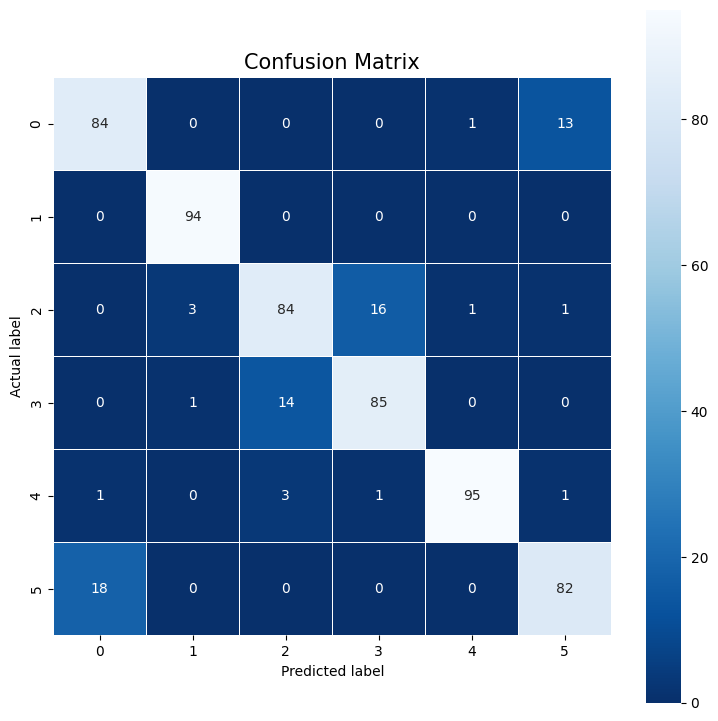

time: 1.7 s (started: 2023-12-05 17:44:22 +00:00)


In [ ]:
X_test = np.hstack((np.stack(test_df["pca_hog"].to_numpy()),
                     np.stack(test_df["pca_vgg16"].to_numpy())))
y_test = test_df["category"]

y_pred = lr.predict(X_test)
accuracy = lr.score(X_test, y_test)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(f"accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix, annot=True, fmt="0", linewidths=.5,
            square = True, cmap = 'Blues_r');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Confusion Matrix'
plt.title(all_sample_title, size = 15)